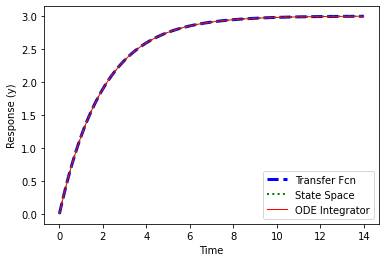

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Simulate taup * dy/dt = -y + K*u
Kp = 3.0
taup = 2.0

# (1) Transfer Function
num = [Kp]
den = [taup,1]
sys1 = signal.TransferFunction(num,den)
t1,y1 = signal.step(sys1)

# (2) State Space
A = -1.0/taup
B = Kp/taup
C = 1.0
D = 0.0
sys2 = signal.StateSpace(A,B,C,D)
t2,y2 = signal.step(sys2)

# (3) ODE Integrator
def model3(y,t):
    u = 1
    return (-y + Kp * u)/taup
t3 = np.linspace(0,14,100)
y3 = odeint(model3,0,t3)

plt.figure(1)
plt.plot(t1,y1,'b--',linewidth=3,label='Transfer Fcn')
plt.plot(t2,y2,'g:',linewidth=2,label='State Space')
plt.plot(t3,y3,'r-',linewidth=1,label='ODE Integrator')
plt.xlabel('Time')
plt.ylabel('Response (y)')
plt.legend(loc='best')
plt.show()

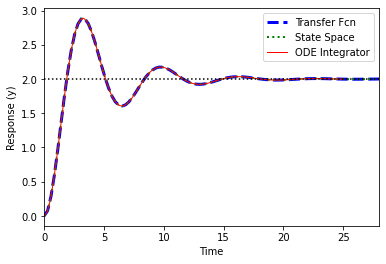

In [2]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# tau * dy2/dt2 + 2*zeta*tau*dy/dt + y = Kp*u
Kp = 2.0    # gain
tau = 1.0   # time constant
zeta = 0.25 # damping factor
theta = 0.0 # no time delay
du = 1.0    # change in u

# (1) Transfer Function
num = [Kp]
den = [tau**2,2*zeta*tau,1]
sys1 = signal.TransferFunction(num,den)
t1,y1 = signal.step(sys1)

# (2) State Space
A = [[0.0,1.0],[-1.0/tau**2,-2.0*zeta/tau]]
B = [[0.0],[Kp/tau**2]]
C = [1.0,0.0]
D = 0.0
sys2 = signal.StateSpace(A,B,C,D)
t2,y2 = signal.step(sys2)

# (3) ODE Integrator
def model3(x,t):
    y = x[0]
    dydt = x[1]
    dy2dt2 = (-2.0*zeta*tau*dydt - y + Kp*du)/tau**2
    return [dydt,dy2dt2]
t3 = np.linspace(0,25,100)
x3 = odeint(model3,[0,0],t3)
y3 = x3[:,0]

plt.figure(1)
plt.plot(t1,y1*du,'b--',linewidth=3,label='Transfer Fcn')
plt.plot(t2,y2*du,'g:',linewidth=2,label='State Space')
plt.plot(t3,y3,'r-',linewidth=1,label='ODE Integrator')
y_ss = Kp * du
plt.plot([0,max(t1)],[y_ss,y_ss],'k:')
plt.xlim([0,max(t1)])
plt.xlabel('Time')
plt.ylabel('Response (y)')
plt.legend(loc='best')
plt.savefig('2nd_order.png')
plt.show()


y1
-10*(-exp(3*t) + 6*exp(3)*log(exp(-t)) + 7*exp(3))*exp(-3*t)*Heaviside(t - 1)/9


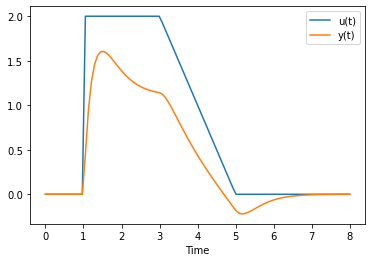

In [3]:
import sympy as sym
from sympy.abc import s,t,x,y,z
import numpy as np
from sympy.integrals import inverse_laplace_transform
import matplotlib.pyplot as plt

# Define inputs
# First step (up) starts at 1 sec
U1 = 2/s*sym.exp(-s)
# Ramp (down) starts at 3 sec
U2 = -1/s**2*sym.exp(-3*s)
# Ramp completes at 5 sec
U3 = 1/s**2*sym.exp(-5*s)

# Transfer function
G = 5*(s+1)/(s+3)**2

# Calculate responses
Y1 = G * U1
Y2 = G * U2
Y3 = G * U3

# Inverse Laplace Transform
u1 = inverse_laplace_transform(U1,s,t)
u2 = inverse_laplace_transform(U2,s,t)
u3 = inverse_laplace_transform(U3,s,t)
y1 = inverse_laplace_transform(Y1,s,t)
y2 = inverse_laplace_transform(Y2,s,t)
y3 = inverse_laplace_transform(Y3,s,t)
print('y1')
print(y1)

# generate data for plot
tm = np.linspace(0,8,100)
us = np.zeros(len(tm))
ys = np.zeros(len(tm))
# substitute numeric values for u and y
for u in [u1,u2,u3]:
    for i in range(len(tm)):
        us[i] += u.subs(t,tm[i])
for y in [y1,y2,y3]:
    for i in range(len(tm)):
        ys[i] += y.subs(t,tm[i])

# plot results
plt.figure()
plt.plot(tm,us,label='u(t)')
plt.plot(tm,ys,label='y(t)')
plt.legend()
plt.xlabel('Time')
plt.show()


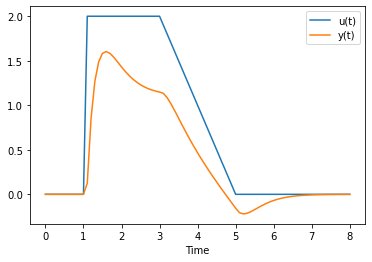

In [6]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

# Create GEKKO model
m = GEKKO()

# Time points for simulation
nt = 81
m.time = np.linspace(0,8,nt)

# Define input
# First step (up) starts at 1 sec
# Ramp (down) starts at 3 sec
# Ramp completes at 5 sec
ut = np.zeros(nt)
ut[11:31] = 2.0
for i in range(31,51):
    ut[i] = ut[i-1] - 0.1

# Define model
u = m.Param(value=ut)
ud = m.Var()
y = m.Var()
dydt = m.Var()
m.Equation(ud==u)
m.Equation(dydt==y.dt())
m.Equation(dydt.dt() + 6*y.dt() + 9*y==5*ud.dt()+5*u)

# Simulation options
m.options.IMODE=7
m.options.NODES=4
m.solve(disp=False)

# plot results
plt.figure()
plt.plot(m.time,u.value,label='u(t)')
plt.plot(m.time,y.value,label='y(t)')
plt.legend()
plt.xlabel('Time')
plt.show()